In [763]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.metrics import classification_report
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [764]:
df = pd.read_csv('combinedData.csv')

# Feature Elimination

In [765]:
df = df.drop(columns=['results', 'seed', 'college', 'collegeOther', 'birthDate', 'win_ratio', 'stint', 
                      'GS', 'GP', 'rebounds', 'fgAttempted', 'ftAttempted','threeAttempted',
                      'minutes', 'pointsFromFieldGoal', 
                      'pos', 'age',
                      'award', 'coachAward',
                      'ftMade', 'topg', 'percentage_pointsFromThree', ]) #'d_reb'

# Encoding

In [766]:
id_features = ['tmID', 'playerID', 'coachID']
categorical_features = ['confID']
df = pd.get_dummies(df, columns=categorical_features)

df

,tmID,year,playerID,points,oRebounds,dRebounds,assists,steals,blocks,turnovers,...,awayW_ratio,min,o_fg%,o_ft%,o_3p%,d_fg%,d_ft%,d_3p%,confID_EA,confID_WE
0,ATL,9,balesal01w,82,20,82,11,15,29,10,...,0.176,6825,39.64,74.76,33.78,44.99,73.97,34.26,True,False
1,ATL,9,castriz01w,269,10,55,52,27,6,57,...,0.176,6825,39.64,74.76,33.78,44.99,73.97,34.26,True,False
2,ATL,9,desouer01w,112,39,40,8,17,21,20,...,0.176,6825,39.64,74.76,33.78,44.99,73.97,34.26,True,False
3,ATL,9,haynikr01w,94,15,41,82,30,4,47,...,0.176,6825,39.64,74.76,33.78,44.99,73.97,34.26,True,False
4,ATL,9,lacyje01w,189,35,54,27,18,6,37,...,0.176,6825,39.64,74.76,33.78,44.99,73.97,34.26,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,WAS,10,langhcr01w,408,101,167,29,34,13,76,...,0.294,6875,42.31,70.13,32.63,43.27,75.50,33.89,True,False
2144,WAS,10,mannkr01w,25,2,12,6,3,0,3,...,0.294,6875,42.31,70.13,32.63,43.27,75.50,33.89,True,False
2145,WAS,10,melvich01w,201,79,79,36,34,29,50,...,0.294,6875,42.31,70.13,32.63,43.27,75.50,33.89,True,False
2146,WAS,10,mosbybe01w,46,15,22,3,8,1,16,...,0.294,6875,42.31,70.13,32.63,43.27,75.50,33.89,True,False


In [767]:
label_encoder = LabelEncoder()
encoding_map = {}

for feature in id_features:
    df[f'{feature}_encoded'] = label_encoder.fit_transform(df[feature])




df['playoff'] = df['playoff'].replace({'N': 0, 'Y': 1})


new_id_features = id_features.copy()
new_id_features.append('year')

# save a new map with each tmID and its encoded value, only with the tmIDs of the 10th year

id_df = df['tmID'].copy()

id_df = id_df.reset_index()
id_df = id_df.drop(columns=['index'])
id_df = id_df.drop_duplicates()
id_df = id_df.reset_index()

# transform tmID into an array of the tmIds
tmIDs = id_df['tmID'].to_numpy()
print(tmIDs)


df = df.drop(columns=id_features)

['ATL' 'CHA' 'CHI' 'CLE' 'CON' 'DET' 'HOU' 'IND' 'LAS' 'MIA' 'MIN' 'NYL'
 'ORL' 'PHO' 'POR' 'SAC' 'SAS' 'SEA' 'UTA' 'WAS']


In [768]:
feature_cols = [col for col in df.columns if col not in ['playoff']]

# Data Leakage

features not to replace with last years:
 - tmID
 - year
 - playerID
 - stint
 - pos
 - height
 - weight
 - college
 - college other
 - birthDate
 - age
 - coachId
 - coachStint
 - confID

In [769]:
features_to_replace = [col for col in feature_cols if col not in [
    'tmID', 'year', 'playerID', 'stint', 'coachID', 'coachStint', 'confID',
    'tmID_encoded', 'playerID_encoded', 'coachID_encoded','confID_EA','confID_WE']]

print(features_to_replace)

['points', 'oRebounds', 'dRebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgMade', 'threeMade', 'dq', 'mpg', 'ppg', 'apg', 'rpg', 'spg', 'bpg', 'pfpg', 'fg%', '3p%', 'ft%', 'orpg', 'drpg', 'percentage_pointsFromFieldGoal', 'percentage_pointsFromFreeThrow', 'height', 'weight', 'coachWon', 'coachLost', 'coach W/L Ratio', 'o_fga', 'o_fta', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'homeW_ratio', 'awayW_ratio', 'min', 'o_fg%', 'o_ft%', 'o_3p%', 'd_fg%', 'd_ft%', 'd_3p%']


In [770]:
df.to_csv('featureRemoval.csv')
df

,year,points,oRebounds,dRebounds,assists,steals,blocks,turnovers,PF,fgMade,...,o_ft%,o_3p%,d_fg%,d_ft%,d_3p%,confID_EA,confID_WE,tmID_encoded,playerID_encoded,coachID_encoded
0,9,82,20,82,11,15,29,10,37,30,...,74.76,33.78,44.99,73.97,34.26,True,False,0,25,36
1,9,269,10,55,52,27,6,57,39,96,...,74.76,33.78,44.99,73.97,34.26,True,False,0,85,36
2,9,112,39,40,8,17,21,20,48,48,...,74.76,33.78,44.99,73.97,34.26,True,False,0,122,36
3,9,94,15,41,82,30,4,47,41,30,...,74.76,33.78,44.99,73.97,34.26,True,False,0,199,36
4,9,189,35,54,27,18,6,37,97,74,...,74.76,33.78,44.99,73.97,34.26,True,False,0,261,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,10,408,101,167,29,34,13,76,74,163,...,70.13,32.63,43.27,75.50,33.89,True,False,19,265,40
2144,10,25,2,12,6,3,0,3,9,10,...,70.13,32.63,43.27,75.50,33.89,True,False,19,297,40
2145,10,201,79,79,36,34,29,50,101,84,...,70.13,32.63,43.27,75.50,33.89,True,False,19,319,40
2146,10,46,15,22,3,8,1,16,29,17,...,70.13,32.63,43.27,75.50,33.89,True,False,19,338,40


# Format Final Year Results

In [771]:
#make a function that receives a dataframe with tmID and playerID, a array of zeros and ones representing the playoff, and a two dimentional array of floats representing the certaintity of the predictions, and returns a dataframe with the tmID, playerID, playoff, and the predictions

def create_predictions_df(data, playoffs, certainties):
    data = data.reset_index(drop=True)
    # Create a DataFrame for the playoffs and certainties
    playoffs_df = pd.DataFrame({
        'playoff': playoffs,
        'certainty': certainties[:, 1] * 100  # Assuming certainties is the output of predict_proba
    })
    
    

    # # change the tmID and playerID to their original values based on the id_df
    data['tmID'] = data['tmID_encoded'].apply(lambda x: tmIDs[x])

    # # Concatenate the original data with the new DataFrame
    result = pd.concat([data[['tmID', 'confID_EA']], playoffs_df], axis=1)
    
        
    # # for every team, find the average certainty and return the teamID and the average certainty and the playoff
    result = result.groupby(['tmID']).mean()
    result = result.reset_index()

    result['playoff'] = result['certainty'].apply(lambda x: 1 if x >= 50 else 0)

    result = result.sort_values(by=['confID_EA'], ascending=False)
    return result

# Decision Tree

In [772]:
yearsInit = 6

In [773]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = DecisionTreeClassifier()

for i in range(yearsInit, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    model.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = model.predict(X_test)
    prediction_probabilities = model.predict_proba(X_test)
    prediction_probabilities = np.around(prediction_probabilities, decimals=4)

    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is t

/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1507958908.py:35: SettingWithCopyWarning: 
A value is t

In [774]:
pred_df = create_predictions_df(X_test, player_predictions, prediction_probabilities)
pred_df

,tmID,confID_EA,playoff,certainty
0,ATL,1.0,0,0.0
1,CHI,1.0,0,0.0
2,CON,1.0,1,100.0
3,DET,1.0,1,100.0
4,IND,1.0,1,100.0
7,NYL,1.0,1,100.0
12,WAS,1.0,0,0.0
5,LAS,0.0,1,100.0
6,MIN,0.0,0,0.0
8,PHO,0.0,0,0.0


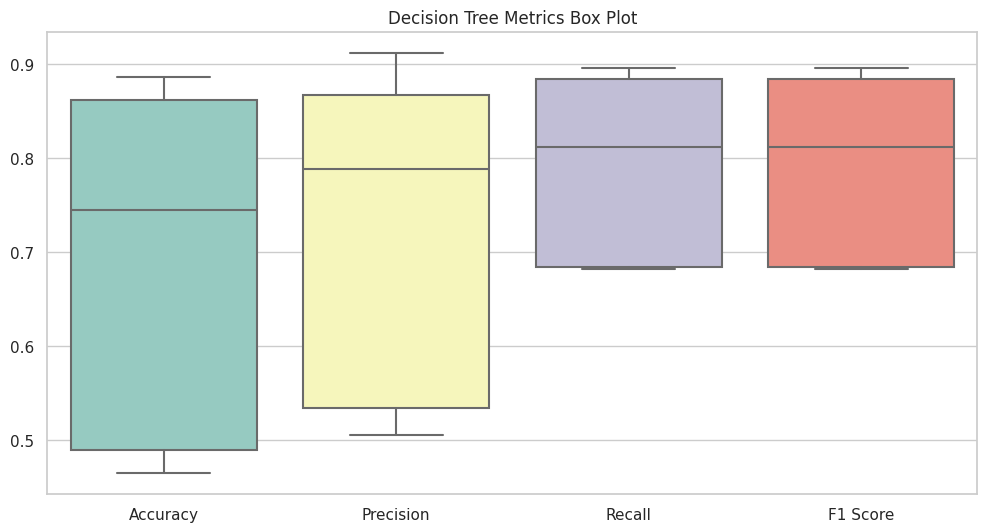

In [775]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("Decision Tree Metrics Box Plot")

plt.show()


In [776]:
accuracy_average = round(sum(accuracies)/len(accuracies), 3)
precision_average = round(sum(precisions)/len(precisions), 3)
recall_average = round(sum(recalls)/len(recalls), 3)
f1s_average = round(sum(f1s)/len(f1s), 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 69.0%
Precision Average: 72.2%
Recall Average: 79.2%
F1 Average: 79.2%


In [777]:
dot_data = export_graphviz(model, out_file=None,
                          feature_names=X_train.columns, # Specify your feature names
                          class_names=['No Playoff', 'Playoff'], # Specify your class names
                          filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree") # This will save the tree as 'decision_tree.pdf'
#graph.view("decision_tree")   # This will open the tree in your default PDF viewer


'decision_tree.pdf'

# Random Forest

In [778]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = RandomForestClassifier()

for i in range(yearsInit, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    model.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = model.predict(X_test)
    prediction_probabilities = model.predict_proba(X_test)
    prediction_probabilities = np.around(prediction_probabilities, decimals=4)

    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is t

/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3750518038.py:35: SettingWithCopyWarning: 
A value is t

In [779]:
pred_df = create_predictions_df(X_test, player_predictions, prediction_probabilities)
pred_df

,tmID,confID_EA,playoff,certainty
0,ATL,1.0,0,0.0
1,CHI,1.0,0,0.0
2,CON,1.0,1,100.0
3,DET,1.0,1,100.0
4,IND,1.0,1,100.0
7,NYL,1.0,1,100.0
12,WAS,1.0,0,2.0
5,LAS,0.0,1,100.0
6,MIN,0.0,0,0.0
8,PHO,0.0,0,0.0


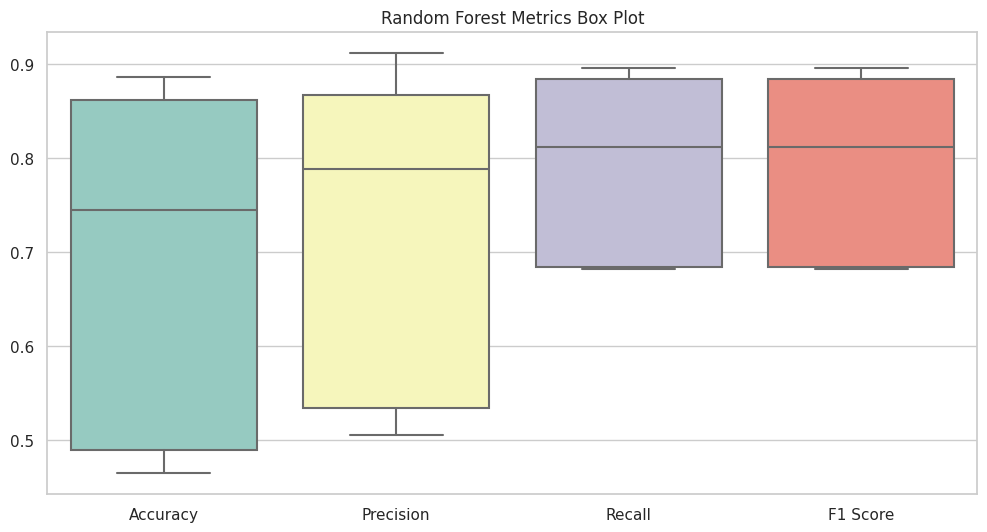

In [780]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("Random Forest Metrics Box Plot")

plt.show()

In [781]:
accuracy_average = round(sum(accuracies)/len(accuracies), 3)
precision_average = round(sum(precisions)/len(precisions), 3)
recall_average = round(sum(recalls)/len(recalls), 3)
f1s_average = round(sum(f1s)/len(f1s), 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 69.0%
Precision Average: 72.2%
Recall Average: 79.2%
F1 Average: 79.2%


# SVM

In [782]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = SVC(kernel='linear', probability=True)

for i in range(yearsInit, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    model.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = model.predict(X_test)
    prediction_probabilities = model.predict_proba(X_test)

    
    # convert pred_array to 4 decimal places, taking into account it is 2 dimentional array
    prediction_probabilities = np.around(prediction_probabilities, decimals=4)

    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print(f"year {i} done")

/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is tryin

year 6 done


/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is tryin

year 7 done


/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is tryin

year 8 done


/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is tryin

year 9 done


/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/241891176.py:35: SettingWithCopyWarning: 
A value is tryin

year 10 done


In [783]:
pred_df = create_predictions_df(X_test, player_predictions, prediction_probabilities)
pred_df

,tmID,confID_EA,playoff,certainty
0,ATL,1.0,0,0.000000
1,CHI,1.0,0,0.000000
2,CON,1.0,1,100.000000
3,DET,1.0,1,100.000000
4,IND,1.0,1,100.000000
7,NYL,1.0,1,96.267778
12,WAS,1.0,0,0.000000
5,LAS,0.0,1,100.000000
6,MIN,0.0,0,11.587500
8,PHO,0.0,0,0.000000


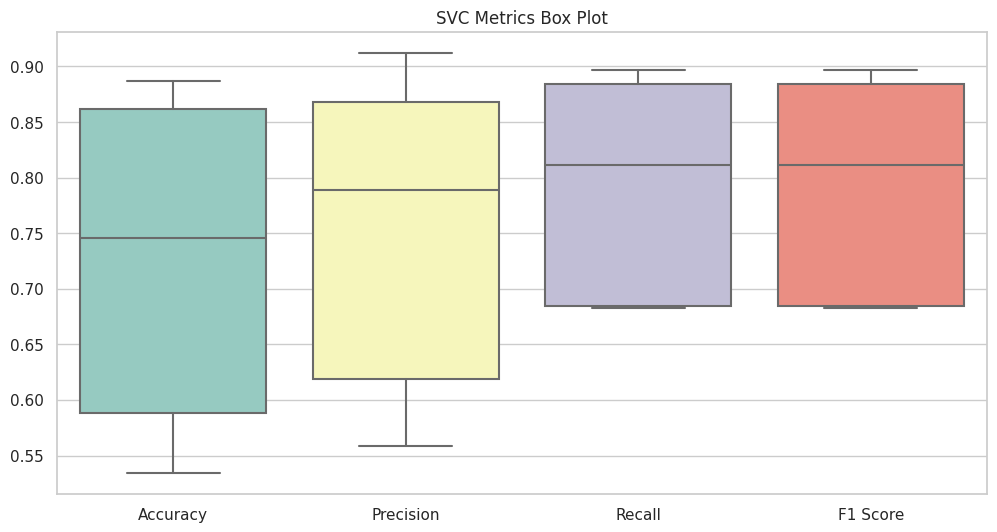

In [784]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("SVC Metrics Box Plot")

plt.show()

In [785]:
accuracy_average = round(sum(accuracies)/len(accuracies), 3)
precision_average = round(sum(precisions)/len(precisions), 3)
recall_average = round(sum(recalls)/len(recalls), 3)
f1s_average = round(sum(f1s)/len(f1s), 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 72.3%
Precision Average: 74.9%
Recall Average: 79.2%
F1 Average: 79.2%


# KNN

In [786]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = KNeighborsClassifier(n_neighbors=5)

for i in range(yearsInit, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    model.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = model.predict(X_test)
    prediction_probabilities = model.predict_proba(X_test)
    prediction_probabilities = np.around(prediction_probabilities, decimals=4)


    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print(f"year {i} done")

/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is t

year 6 done


/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is t

year 7 done


/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is t

year 8 done


/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is t

year 9 done


/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is t

year 10 done


/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/3303578098.py:35: SettingWithCopyWarning: 
A value is t

In [787]:
pred_df = create_predictions_df(X_test, player_predictions, prediction_probabilities)
pred_df

,tmID,confID_EA,playoff,certainty
0,ATL,1.0,0,0.000000
1,CHI,1.0,0,14.285714
2,CON,1.0,1,100.000000
3,DET,1.0,1,100.000000
4,IND,1.0,1,100.000000
7,NYL,1.0,1,100.000000
12,WAS,1.0,0,2.857143
5,LAS,0.0,1,100.000000
6,MIN,0.0,0,0.000000
8,PHO,0.0,0,5.000000


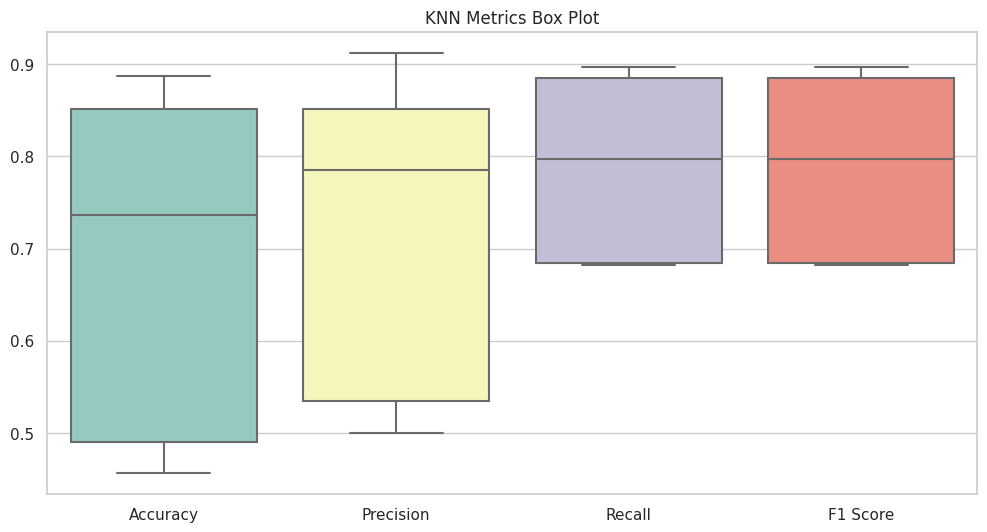

In [788]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("KNN Metrics Box Plot")

plt.show()

In [789]:
accuracy_average = round(sum(accuracies)/len(accuracies), 3)
precision_average = round(sum(precisions)/len(precisions), 3)
recall_average = round(sum(recalls)/len(recalls), 3)
f1s_average = round(sum(f1s)/len(f1s), 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 68.4%
Precision Average: 71.7%
Recall Average: 78.9%
F1 Average: 78.9%


# Naive Bayes

In [790]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = GaussianNB()

for i in range(yearsInit, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    model.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = model.predict(X_test)
    prediction_probabilities = model.predict_proba(X_test)
    prediction_probabilities = np.around(prediction_probabilities, decimals=4)


    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print(f"year {i} done")

/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is t

year 6 done


/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is t

year 7 done


/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is t

year 8 done


/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is t

year 9 done


/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is t

year 10 done


/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_32649/1086411336.py:35: SettingWithCopyWarning: 
A value is t

In [791]:
pred_df = create_predictions_df(X_test, player_predictions, prediction_probabilities)
pred_df

,tmID,confID_EA,playoff,certainty
0,ATL,1.0,0,0.000000
1,CHI,1.0,0,29.272857
2,CON,1.0,1,100.000000
3,DET,1.0,1,100.000000
4,IND,1.0,1,79.088333
7,NYL,1.0,1,91.732222
12,WAS,1.0,0,0.001429
5,LAS,0.0,1,100.000000
6,MIN,0.0,0,29.912500
8,PHO,0.0,0,24.991250


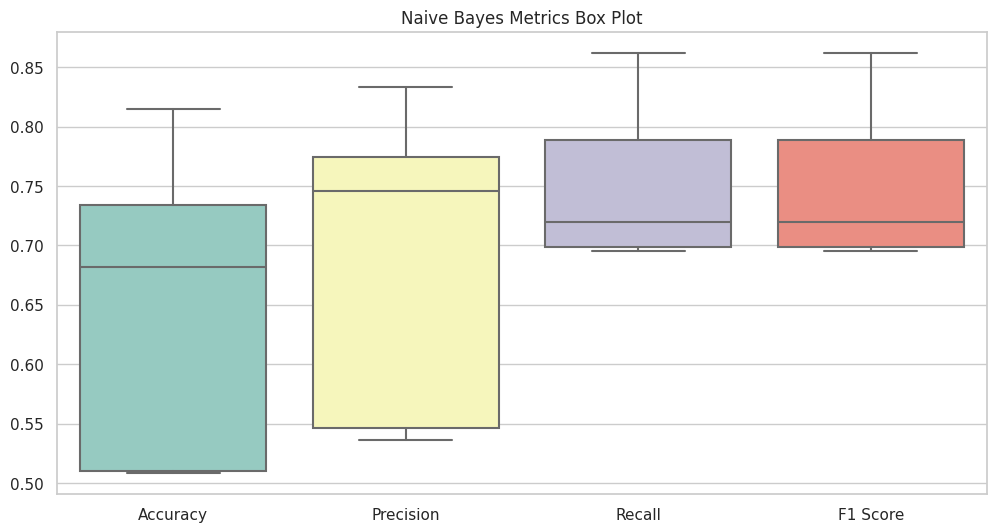

In [792]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("Naive Bayes Metrics Box Plot")

plt.show()

In [793]:
accuracy_average = round(sum(accuracies)/len(accuracies), 3)
precision_average = round(sum(precisions)/len(precisions), 3)
recall_average = round(sum(recalls)/len(recalls), 3)
f1s_average = round(sum(f1s)/len(f1s), 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 65.0%
Precision Average: 68.7%
Recall Average: 75.3%
F1 Average: 75.3%


# Neural Network

In [26]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = MLPClassifier(max_iter=500, learning_rate_init=0.001, batch_size=64)

layers = [(x,) for x in range(25, 100, 25)] 
layers += [(x, y) for x in range(25, 100, 25) for y in range(25, 100, 25)] 

param_grid = {
    'hidden_layer_sizes': layers,
    'activation': ['relu', 'logistic', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(model, param_grid, cv=10)

for i in range(yearsInit, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    grid_search.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = grid_search.predict(X_test)
    prediction_probabilities = model.predict_proba(X_test)
    prediction_probabilities = np.around(prediction_probabilities, decimals=4)


    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print(f"year {i} done")

/tmp/ipykernel_6005/1655631462.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_6005/1655631462.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_6005/1655631462.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_6005/1655631462.py:46: SettingWithCopyWarning: 
A value is tryin

In [ ]:
pred_df = create_predictions_df(X_test, player_predictions, prediction_probabilities)
pred_df

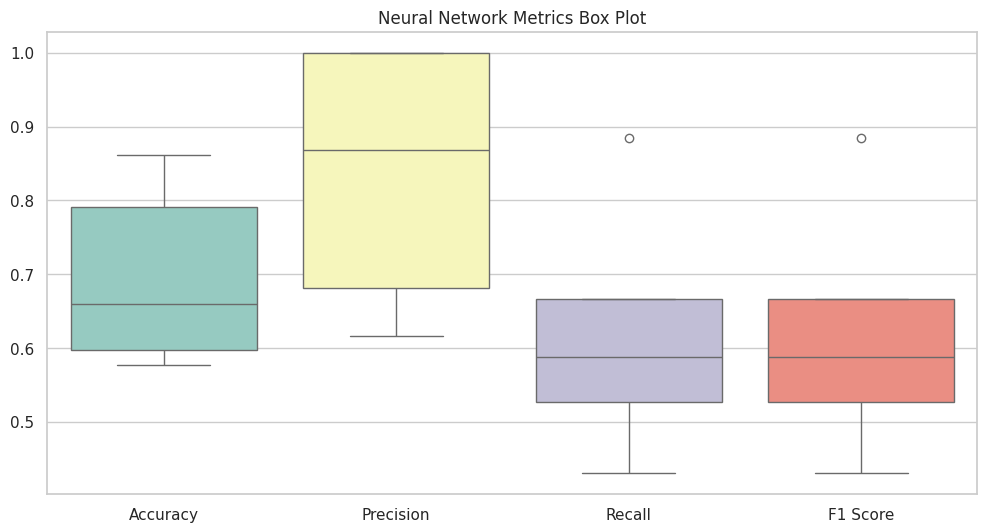

In [ ]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("Neural Network Metrics Box Plot")

plt.show()

In [ ]:
accuracy_average = round(sum(accuracies)/len(accuracies), 3)
precision_average = round(sum(precisions)/len(precisions), 3)
recall_average = round(sum(recalls)/len(recalls), 3)
f1s_average = round(sum(f1s)/len(f1s), 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 69.8%
Precision Average: 83.3%
Recall Average: 61.9%
F1 Average: 61.9%
